# Summary
In this notebook we analysze the model behaviour on SHL test set when different number of channels are off

# Load models and Data

## Models

In [2]:
# Taken from /home/david/Desktop/projects/thesis/combined_downstream_upstream/code/V9c-different-seeds-impute-only-missing.py
import pandas as pd
import numpy as np
import os
os.chdir("/home/david/Desktop/projects/thesis/")

upstream_params = {
    'input_dimension': 12,
    'output_dimension': 12,              
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': 8,               # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'positional_encodings': False,
    'device':'cuda'
}
best_rocauc_and_pr_auc = {
    'seed':[],
    'validation-roc-auc':[],
    'validation-pr-auc':[],
    'test-roc-auc':[],
    'test-pr-auc':[],
}


import numpy as np
import pickle 

from combined_downstream_upstream.modeling.JointModel import CombinedModel
from combined_downstream_upstream.utils.LoadModels import *
from combined_downstream_upstream.executors.train_combined_model import trainer

# load model
# SHL impute only missing
upstream_model   = load_upstream_model(upstream_params, 
                                        folder_path = './upstream_seq2seq/models/', 
                                        model_name = 'transformer_cnn_4heads',
                                        device='cpu',
                                        cold_start=False)
downstream_model = load_downstream_model(dropout=0.5,
                                         device='cpu',
                                        scale=1,
                                        num_inputs=12, 
                                        weights_path='./downstream_classification/models/AF-V10-different-seeds-registered/model_val_rocauc.pt',
                                        cold_start=False)

model = CombinedModel(upstream_model, downstream_model, device='cpu', continue_training_upstream_model=False, impute_only_missing=True)
model = model.to('cpu')

checkpoint = torch.load("/home/david/Desktop/projects/thesis/combined_downstream_upstream/models/AF-V9c-different-seeds/model_val_rocauc.pt")
model.load_state_dict(checkpoint)
model.eval()



Upstream Model File Path: ./upstream_seq2seq/models/transformer_cnn_4heads_1701990699.9536803.pt
Num attention heads: 8


/home/david/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CombinedModel(
  (upstream_model): TSTransformerEncoderCNN(
    (project_input): Linear(in_features=12, out_features=128, bias=True)
    (encoder): Linear(in_features=12, out_features=128, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.4, inplace=False)
          (dropout2): Dropout(p=0.4, inplace=False)
        )
      )
    )
    (output_layer): Linear(in_features=128, out_fea

## Data


In [5]:
from downstream_classification.dataloader.DataGenerator import DataGenerator, DataGenerator_ptb
metadata_file_path = './downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv'
data_folder_path = './downstream_classification/data/individual-signals-registered/'
targets = ['AF']
batch_size = 128
seed = 42

test_generator = DataGenerator(
    metadata_file_path= metadata_file_path,                 # path to metadata file
    data_folder_path = data_folder_path,                    # path to individual signals
    sample='test',                                          # sample we want to create a generator to. Either train, validation or test
    targets=targets,                                        # list of targets we want train on
    batch_size=batch_size,                                  # batch size
    shuffle=False,                                            # Whether to shuffle the list of IDs at the end of each epoch.
    seed = seed
        )

# Extract scores and Num of leads

In [9]:
metadata_table = pd.read_csv(metadata_file_path, index_col=0)[['sample','reading',"AF"]]
metadata_table

,sample,reading,AF
0,train,427805,1.0
1,train,356921,0.0
2,train,428248,0.0
3,train,440621,1.0
4,train,32229,1.0
...,...,...,...
371302,test,387849,0.0
371303,test,395752,0.0
371304,test,434377,0.0
371305,test,384590,0.0


In [177]:
device = 'cpu'
loss_function_weight = None
reconstruction_criterion = nn.MSELoss(reduction='none')

def process(X, device):
    src_ = np.float32(np.transpose(X, axes=(2,0,1)))
    src_ = torch.from_numpy(src_).to(device)
    return src_

from tqdm import trange
T = len(test_generator)
t = trange(T, desc='Within epoch loss (validation)', leave=True)
it = iter(test_generator)


readings = []   # for merge
ys = []         # for verification
outputs = []    # for analysis
mchannels = []  # for analysis
mse = []        # for analysis

dict_with_Xs_Xhats_and_signal = {
    'X':[],
    'X_recon':[],
    'reading':[],
    'mchanels':[]
}

with torch.no_grad():
    for i in t:

        # get data
        X, y, readings_batch = next(it)
        
        # don't run if there are NaNs
        if np.isnan(X).sum()>0:
            print('skipping because of NaNs')
            continue
        y = np.float32(y)
        
        X = process(X, device)    
        # X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        # convert loss_function_weight
        if loss_function_weight is not None:
            weights = torch.where(y == 1., loss_function_weight, 1)
        else:
            weights = torch.where(y == 1, 1, 1)
        weights = weights.to(device)

        X = X.to(device)
        y = y.to(device)
        

        outputs_bach = model(X)
        outputs_bach = outputs_bach.numpy().reshape(-1)
        reconstruction_X = model.upstream_model(X,None)

        # get reconstruction loss
        X_perm = X.permute((1,2,0)) # [450, 128, 12] ->[128,12,450]
        reconstruction_X = reconstruction_X.permute((1,2,0))
        non_zero_mask = X_perm.abs().sum(dim=-1) != 0
        filtered_output = X_perm[non_zero_mask]
        filtered_target = reconstruction_X[non_zero_mask]
        
        # get current relevant loss
        mse_batch = reconstruction_criterion(filtered_target, filtered_output)
        mse_per_example = mse_batch.view(128, -1).mean(dim=-1)
        mse_per_example = mse_per_example.numpy().reshape(-1)

        missing_channels = [((X_perm.numpy()[j]==0).sum(1) == 450).sum() for j in range(X_perm.shape[0])]

        for j in range(batch_size):
            readings.append(readings_batch[j])
            ys.append(y.numpy().reshape(-1)[j])
            outputs.append(outputs_bach[j])
            mchannels.append(missing_channels[j])
            mse.append(mse_per_example[j])

            dict_with_Xs_Xhats_and_signal['X'].append(X_perm[j])
            dict_with_Xs_Xhats_and_signal['X_recon'].append(reconstruction_X[j])
            dict_with_Xs_Xhats_and_signal['reading'].append(readings_batch[j])
            dict_with_Xs_Xhats_and_signal['mchanels'].append(missing_channels[j])
        
        # if i == 10:
        #     break

test_results_df = pd.DataFrame({
    'reading':readings,
    'y_comparison': ys,
    'y_pred':outputs,
    'missing_channels':mchannels,
    'mse':mse,
})
test_results_df

Within epoch loss (validation): 100%|██████████| 433/433 [43:13<00:00,  5.99s/it]


,reading,y_comparison,y_pred,missing_channels,mse
0,487286,1.0,0.102641,0,0.130584
1,468825,0.0,0.112285,0,0.012104
2,304101,0.0,0.158145,0,0.065472
3,540684,0.0,0.150457,0,0.139542
4,469169,0.0,0.577750,0,0.083333
...,...,...,...,...,...
55419,150001,0.0,0.371814,0,0.055868
55420,283138,0.0,0.141960,0,0.084118
55421,459978,0.0,0.429091,0,0.090655
55422,387325,0.0,0.162006,0,0.095639


In [178]:
test_results_df.to_csv('predictions_on_test.csv')


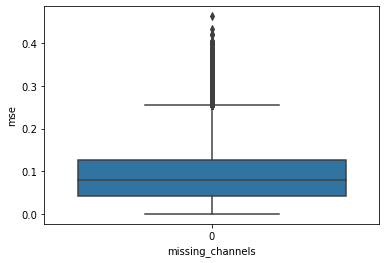

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_df = metadata_table.merge(test_results_df, on = 'reading', how='right')
equal_share = (temp_df["AF"] == temp_df['y_comparison']).mean()
assert equal_share==1, 'Some labels are not consistent'

sns.boxplot(data = temp_df,x='missing_channels', y='mse')
plt.show()

In [ ]:
def plot_reconstruction(reading, dict_with_Xs_Xhats_and_signal,trim_tails = 0):
    import numpy as np
    import matplotlib.pyplot as plt

    ind = dict_with_Xs_Xhats_and_signal['reading'].index(reading)

    X = dict_with_Xs_Xhats_and_signal['X'][ind]
    X_recon = dict_with_Xs_Xhats_and_signal['X_recon'][ind]
    missing = dict_with_Xs_Xhats_and_signal['mchanels'][ind]

    X = X[:,trim_tails:(450-trim_tails)]
    X_recon = X_recon[:,trim_tails:(450-trim_tails)]

    fig, axes = plt.subplots(6, 2, figsize=(10, 12))
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        ax.plot(X[i, :], label=f"Reading")
        # ax.plot(X_recon[i, :], label=f"Recon")
        
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
    fig.legend(["Original Data", "Reconstructed Data"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    fig.suptitle(f"{missing} Missing Channels", fontsize=16)

    plt.tight_layout()
    plt.show()

for read in temp_df.sample(n=30)['reading'].values:
    plot_reconstruction(read, dict_with_Xs_Xhats_and_signal, trim_tails=5)


# Using old code
taken from Notebook 1.1

In [192]:
shl_data_generator = DataGenerator(
    metadata_file_path = f'./downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
    # data_folder_path = f'{downstream_classification_path_linux}/data/individual-signals/',
    data_folder_path = './downstream_classification/data/individual-signals/',
    batch_size=4,
    targets = ['AF'], 
    sample = 'test',
    seed = 42
    )


X,y, signal_names = shl_data_generator.__getitem__(1224)
# print(X.shape, signal_names.shape)
X,signal_names

(array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.79769671, 0.78245504, 0.7687068 , ..., 0.81351574,
          0.81592152, 0.8151701 ],
         [0.45254355, 0.45652231, 0.46198654, ..., 0.38745968,
          0.3871216 , 0.39427737],
         [0.11376316, 0.12691053, 0.12905148, ..., 0.02111123,
          0.04570366, 0.08900783]],
 
        [[0.37760244, 0.40355412, 0.40595379, ..., 0.40959348,
          0.3998476 , 0.40001477],
         [0.2132609 , 0.21538412, 0.21554126, ..., 0.19350438,
          0.19553303, 0.21654378],
         [0.20543893, 0.1857515 , 0.18450069, ..., 0.15720091,
          0.16805813, 0.19856522],
         ...,
         [0.35612658, 0.35533081, 0.35623721, ..., 0.32766677,
          0.33801042, 0.

In [193]:
signal_names

[297002, 200337, 417561, 253935]

**Here it looks like some of the channels ARE empty**. Let's look at some

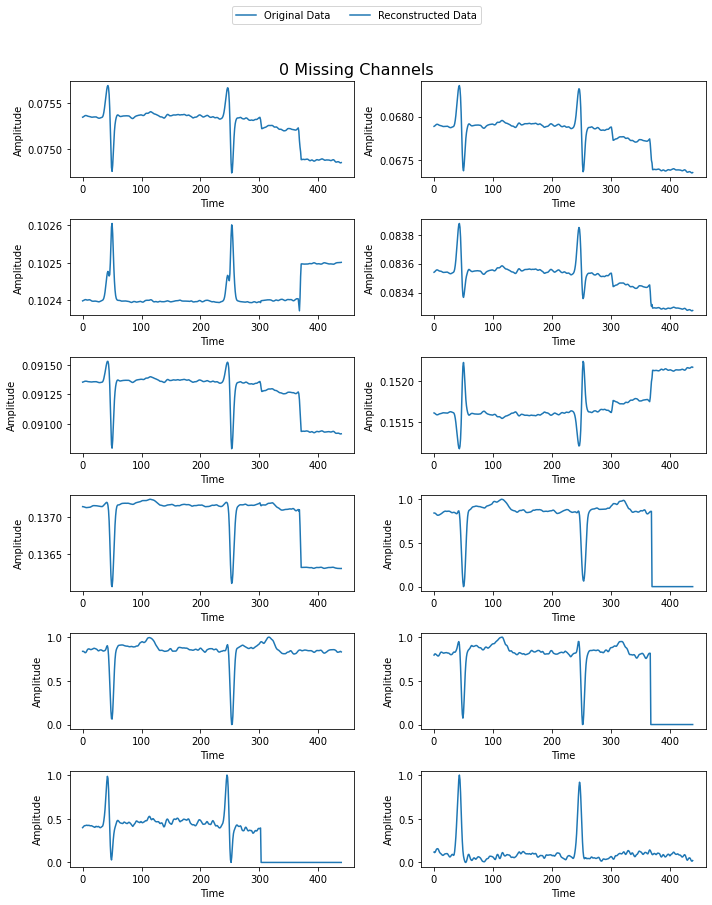

In [194]:
plot_reconstruction(297002, dict_with_Xs_Xhats_and_signal, trim_tails=5)

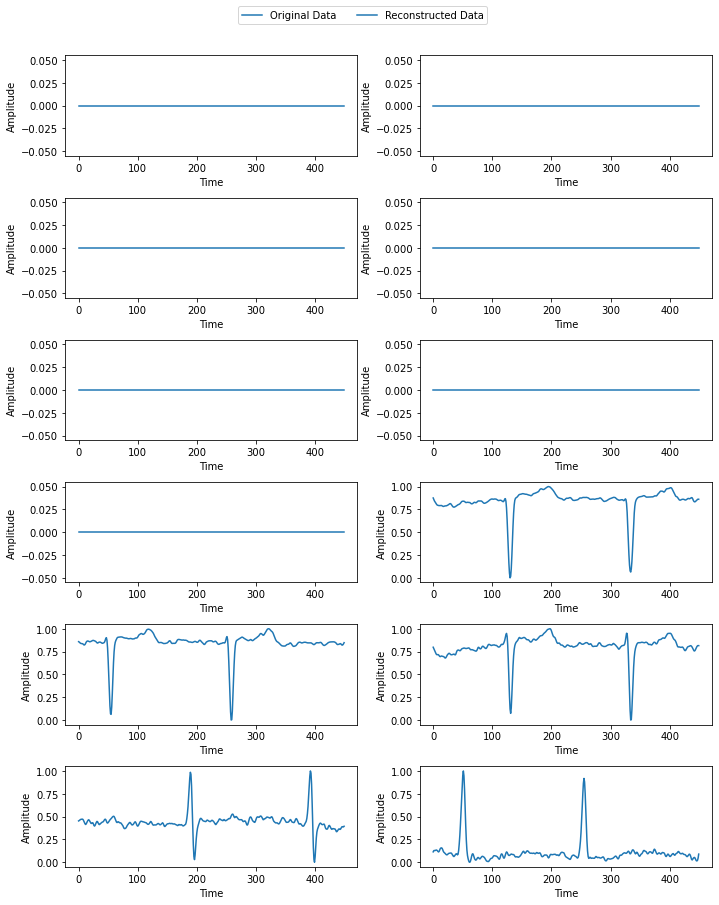

In [197]:

import numpy as np
import matplotlib.pyplot as plt

ind = dict_with_Xs_Xhats_and_signal['reading'].index(reading)

X = X[0]
fig, axes = plt.subplots(6, 2, figsize=(10, 12))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    ax.plot(X[i, :], label=f"Reading")
    # ax.plot(X_recon[i, :], label=f"Recon")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
fig.legend(["Original Data", "Reconstructed Data"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.show()

# Another trial

In [1]:
import os
os.chdir("/home/david/Desktop/projects/thesis/")

from downstream_classification.dataloader.DataGenerator import DataGenerator, DataGenerator_ptb
import pandas as pd
import numpy as np

shl_data_generator = DataGenerator(
    metadata_file_path = f'./downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
    # data_folder_path = f'{downstream_classification_path_linux}/data/individual-signals/',
    data_folder_path = './downstream_classification/data/individual-signals/',
    batch_size=4,
    targets = ['AF'], 
    sample = 'test',
    seed = 42
    )
shl_data_generator_registered = DataGenerator(
    metadata_file_path = f'./downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
    # data_folder_path = f'{downstream_classification_path_linux}/data/individual-signals/',
    data_folder_path = './downstream_classification/data/individual-signals-registered/',
    batch_size=4,
    targets = ['AF'], 
    sample = 'test',
    seed = 42
    )

X,     y,     signal_names     = shl_data_generator.__getitem__(1224)
X_reg, y_reg, signal_names_reg = shl_data_generator_registered.__getitem__(1224)
# print(X.shape, signal_names.shape)
# X,signal_names
signal_names, signal_names_reg


([297002, 200337, 417561, 253935], [297002, 200337, 417561, 253935])

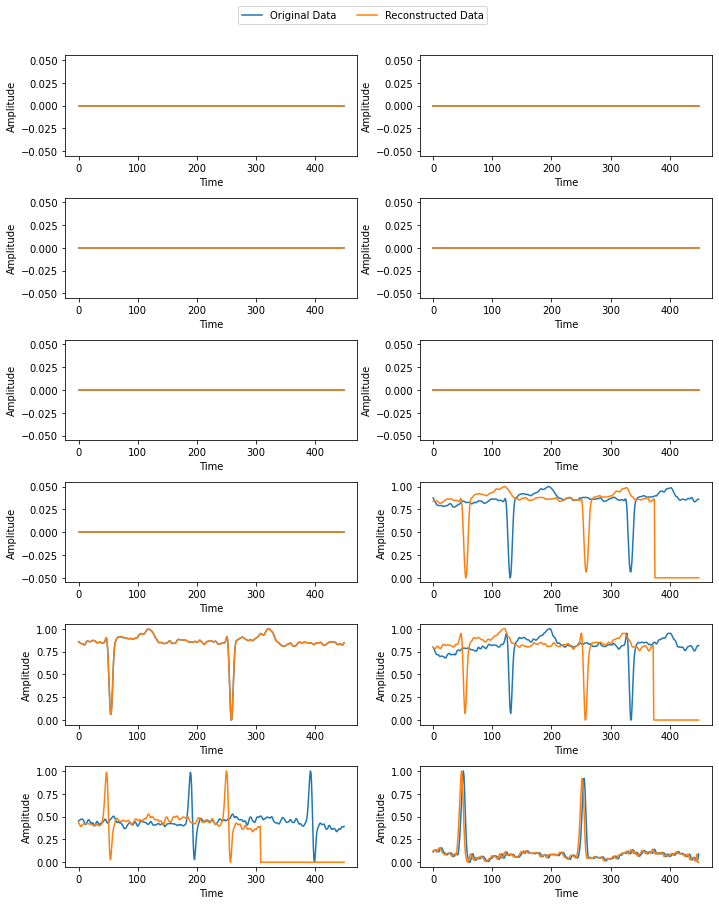

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotter(X,X_reg):
    
    fig, axes = plt.subplots(6, 2, figsize=(10, 12))
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        ax.plot(X[i, :], label=f"Reading")
        ax.plot(X_reg[i, :], label=f"Registered")
        
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
    fig.legend(["Original Data", "Reconstructed Data"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

    plt.tight_layout()
    plt.show()

plotter(X[0],X_reg[0])

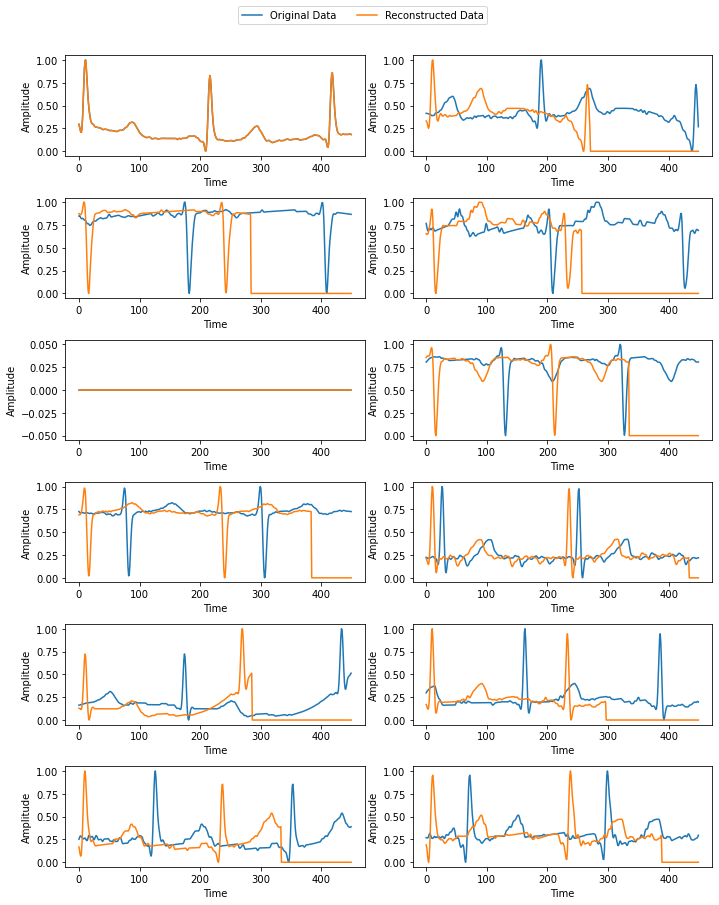

[487286, 468825, 304101, 540684]

In [30]:
X,     y,     signal_names     = shl_data_generator.__getitem__(0)
X_reg, y_reg, signal_names_reg = shl_data_generator_registered.__getitem__(0)
plotter(X[0],X_reg[0])
signal_names

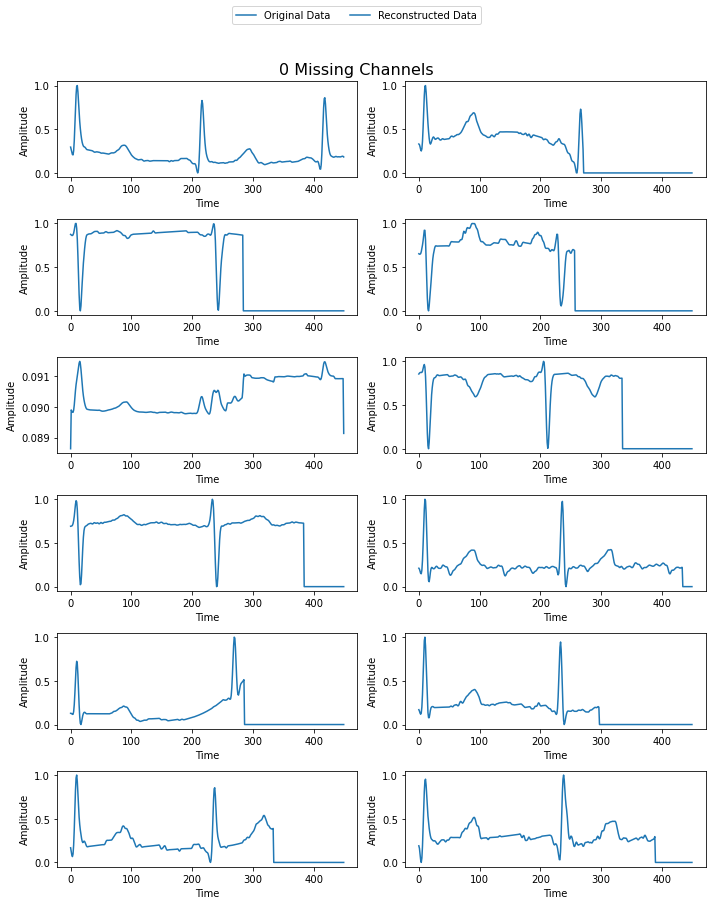

In [31]:
plot_reconstruction(487286,dict_with_Xs_Xhats_and_signal)

there is no bug in the registration. Just in this notebook

## Redo

In [16]:
def plot_reconstruction(reading, dict_with_Xs_Xhats_and_signal,trim_tails = 0):
    import numpy as np
    import matplotlib.pyplot as plt

    ind = dict_with_Xs_Xhats_and_signal['reading'].index(reading)

    X = dict_with_Xs_Xhats_and_signal['X'][ind]
    X_recon = dict_with_Xs_Xhats_and_signal['X_recon'][ind]
    missing = dict_with_Xs_Xhats_and_signal['mchanels'][ind]

    X = X[:,trim_tails:(450-trim_tails)]
    X_recon = X_recon[:,trim_tails:(450-trim_tails)]

    fig, axes = plt.subplots(6, 2, figsize=(10, 12))
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        ax.plot(X[i, :], label=f"Reading")
        # ax.plot(X_recon[i, :], label=f"Recon")
        
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
    fig.legend(["Original Data", "Reconstructed Data"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    fig.suptitle(f"{missing} Missing Channels", fontsize=16)

    plt.tight_layout()
    plt.show()

In [42]:
# Taken from /home/david/Desktop/projects/thesis/combined_downstream_upstream/code/V9c-different-seeds-impute-only-missing.py
import pandas as pd
import numpy as np
import os
os.chdir("/home/david/Desktop/projects/thesis/")

upstream_params = {
    'input_dimension': 12,
    'output_dimension': 12,              
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': 8,               # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'positional_encodings': False,
    'device':'cuda'
}
best_rocauc_and_pr_auc = {
    'seed':[],
    'validation-roc-auc':[],
    'validation-pr-auc':[],
    'test-roc-auc':[],
    'test-pr-auc':[],
}


import numpy as np
import pickle 

from combined_downstream_upstream.modeling.JointModel import CombinedModel
from combined_downstream_upstream.utils.LoadModels import *
from combined_downstream_upstream.executors.train_combined_model import trainer

# load model
# SHL impute only missing
upstream_model   = load_upstream_model(upstream_params, 
                                        folder_path = './upstream_seq2seq/models/', 
                                        model_name = 'transformer_cnn_4heads',
                                        device='cpu',
                                        cold_start=False)
downstream_model = load_downstream_model(dropout=0.5,
                                         device='cpu',
                                        scale=1,
                                        num_inputs=12, 
                                        weights_path='./downstream_classification/models/AF-V10-different-seeds-registered/model_val_rocauc.pt',
                                        cold_start=False)

model = CombinedModel(upstream_model, downstream_model, device='cpu', continue_training_upstream_model=False, impute_only_missing=True)
model = model.to('cpu')

checkpoint = torch.load("/home/david/Desktop/projects/thesis/combined_downstream_upstream/models/AF-V9c-different-seeds/model_val_rocauc.pt")
model.load_state_dict(checkpoint)
model.eval()


Upstream Model File Path: ./upstream_seq2seq/models/transformer_cnn_4heads_1701990699.9536803.pt
Num attention heads: 8


/home/david/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CombinedModel(
  (upstream_model): TSTransformerEncoderCNN(
    (project_input): Linear(in_features=12, out_features=128, bias=True)
    (encoder): Linear(in_features=12, out_features=128, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.4, inplace=False)
          (dropout2): Dropout(p=0.4, inplace=False)
        )
      )
    )
    (output_layer): Linear(in_features=128, out_fea

In [20]:
device = 'cpu'
loss_function_weight = None
reconstruction_criterion = nn.MSELoss(reduction='none')

def process(X, device):
    src_ = np.float32(np.transpose(X, axes=(2,0,1)))
    src_ = torch.from_numpy(src_).to(device)
    return src_

from tqdm import trange
T = len(shl_data_generator_registered)
t = trange(T, desc='Within epoch loss (validation)', leave=True)
it = iter(shl_data_generator_registered)


readings = []   # for merge
ys = []         # for verification
outputs = []    # for analysis
mchannels = []  # for analysis
mse = []        # for analysis

dict_with_Xs_Xhats_and_signal = {
    'X':[],
    'X_recon':[],
    'reading':[],
    'mchanels':[]
}


Within epoch loss (validation):   0%|          | 0/13862 [00:00<?, ?it/s]

In [21]:
with torch.no_grad():
    for i in t:

        # get data
        X, y, readings_batch = next(it)
        
        # don't run if there are NaNs
        if np.isnan(X).sum()>0:
            print('skipping because of NaNs')
            continue
        y = np.float32(y)
        
        X = process(X, device)    
        # X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        # convert loss_function_weight
        if loss_function_weight is not None:
            weights = torch.where(y == 1., loss_function_weight, 1)
        else:
            weights = torch.where(y == 1, 1, 1)
        weights = weights.to(device)

        X = X.to(device)
        y = y.to(device)
        

        outputs_bach = model(X)
        outputs_bach = outputs_bach.numpy().reshape(-1)
        reconstruction_X = model.upstream_model(X,None)

        # get reconstruction loss
        X_perm = X.permute((1,2,0)) # [450, 128, 12] ->[128,12,450]
        reconstruction_X = reconstruction_X.permute((1,2,0))
        non_zero_mask = X_perm.abs().sum(dim=-1) != 0
        filtered_output = X_perm[non_zero_mask]
        filtered_target = reconstruction_X[non_zero_mask]
        
        # get current relevant loss
        mse_batch = reconstruction_criterion(filtered_target, filtered_output)
        mse_per_example = mse_batch.view(4, -1).mean(dim=-1)
        mse_per_example = mse_per_example.numpy().reshape(-1)

        missing_channels = [((X_perm.numpy()[j]==0).sum(1) == 450).sum() for j in range(X_perm.shape[0])]

        for j in range(X_perm.shape[0]):
            readings.append(readings_batch[j])
            ys.append(y.numpy().reshape(-1)[j])
            outputs.append(outputs_bach[j])
            mchannels.append(missing_channels[j])
            mse.append(mse_per_example[j])

            dict_with_Xs_Xhats_and_signal['X'].append(X_perm[j])
            dict_with_Xs_Xhats_and_signal['X_recon'].append(reconstruction_X[j])
            dict_with_Xs_Xhats_and_signal['reading'].append(readings_batch[j])
            dict_with_Xs_Xhats_and_signal['mchanels'].append(missing_channels[j])
        
        if i == 10:
            break

test_results_df = pd.DataFrame({
    'reading':readings,
    'y_comparison': ys,
    'y_pred':outputs,
    'missing_channels':mchannels,
    'mse':mse,
})


Within epoch loss (validation):   0%|          | 10/13862 [00:04<1:52:19,  2.06it/s]


In [22]:
test_results_df

,reading,y_comparison,y_pred,missing_channels,mse
0,487286,1.0,0.102641,0,0.130584
1,468825,0.0,0.112285,0,0.012104
2,304101,0.0,0.158145,0,0.065472
3,540684,0.0,0.150457,0,0.139542
4,469169,0.0,0.577750,0,0.083333
5,268494,0.0,0.144508,0,0.270651
6,379544,0.0,0.328939,0,0.134423
7,463345,0.0,0.115746,0,0.045322
8,290271,0.0,0.323102,0,0.180097
9,538590,0.0,0.133039,0,0.045242


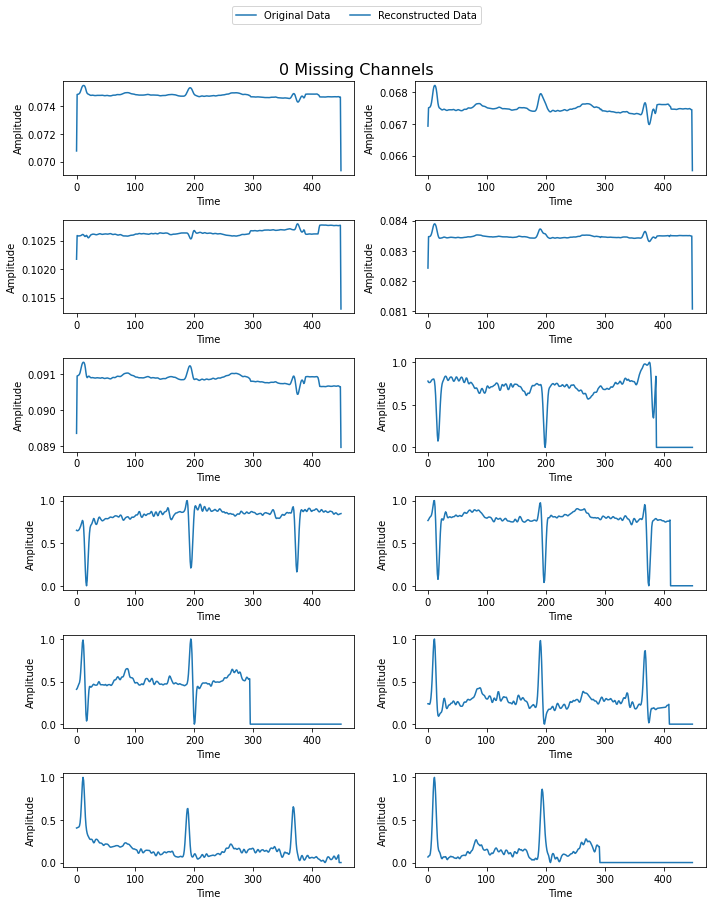

In [23]:
plot_reconstruction(292292,dict_with_Xs_Xhats_and_signal)

# Manually finding the bug

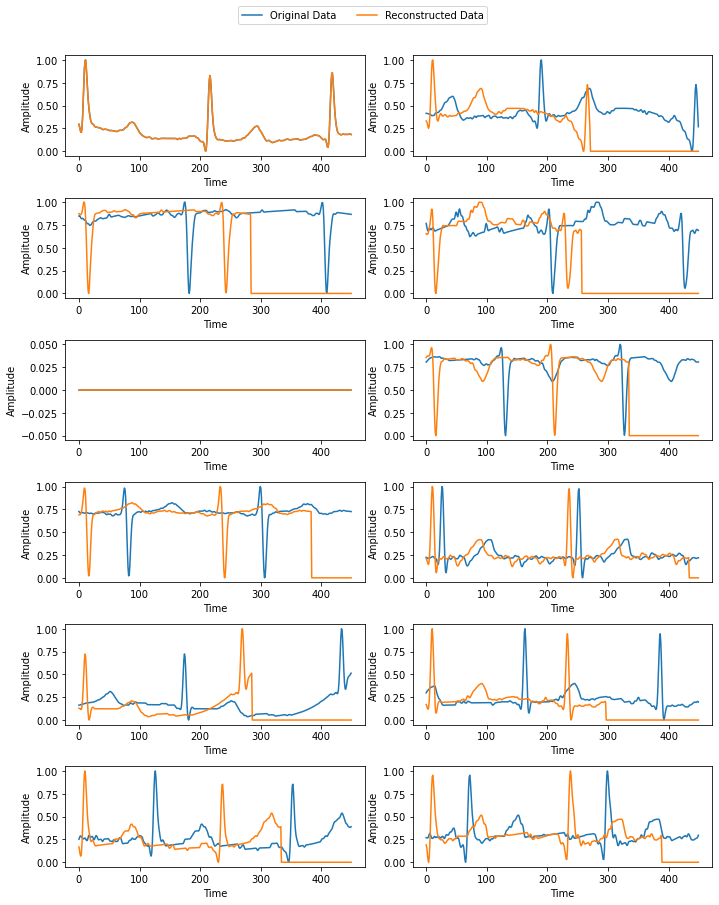

In [32]:
X,     y,     signal_names     = shl_data_generator.__getitem__(0)
X_reg, y_reg, signal_names_reg = shl_data_generator_registered.__getitem__(0)
plotter(X[0],X_reg[0])

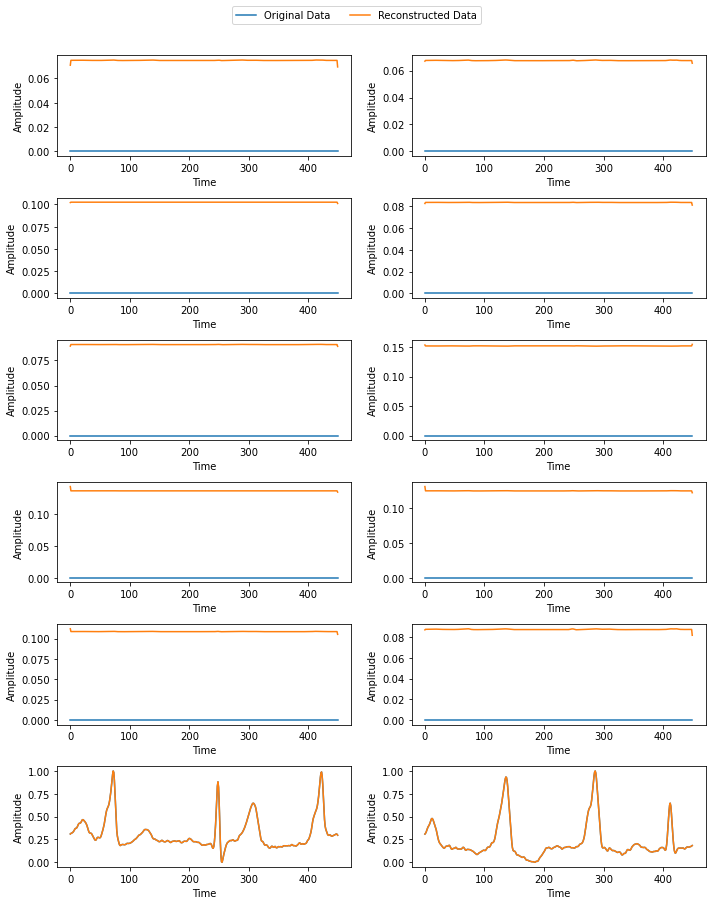

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30971711, 0.31555691, 0.31883361, ..., 0.30999221, 0.30633593,
        0.29601817],
       [0.30856541, 0.31676709, 0.32941538, ..., 0.17350909, 0.17830181,
        0.18296379]])

tensor([[0.0710, 0.0750, 0.0750,  ..., 0.0749, 0.0749, 0.0695],
        [0.0671, 0.0676, 0.0676,  ..., 0.0675, 0.0675, 0.0656],
        [0.1022, 0.1026, 0.1026,  ..., 0.1026, 0.1026, 0.1011],
        ...,
        [0.0872, 0.0878, 0.0878,  ..., 0.0877, 0.0877, 0.0820],
        [0.3097, 0.3156, 0.3188,  ..., 0.3100, 0.3063, 0.2960],
        [0.3086, 0.3168, 0.3294,  ..., 0.1735, 0.1783, 0.1830]])

In [106]:
y = np.float32(y)
X_ = process(X, device)
# plotter(X[0],X_.permute((1,2,0))[0])

with torch.no_grad():
    outputs_bach = model(X_)
    outputs_bach = outputs_bach.numpy().reshape(-1)
    reconstruction_X = model.upstream_model(X_,None)

# get reconstruction loss
X_perm = X_.permute((1,2,0)) # [450, 128, 12] ->[128,12,450]
plotter(X[1],X_perm[1])
display(X[1],X_perm[1])

# Torch draws some random number around 0
`process` is adding an artifact. Think about the consequences

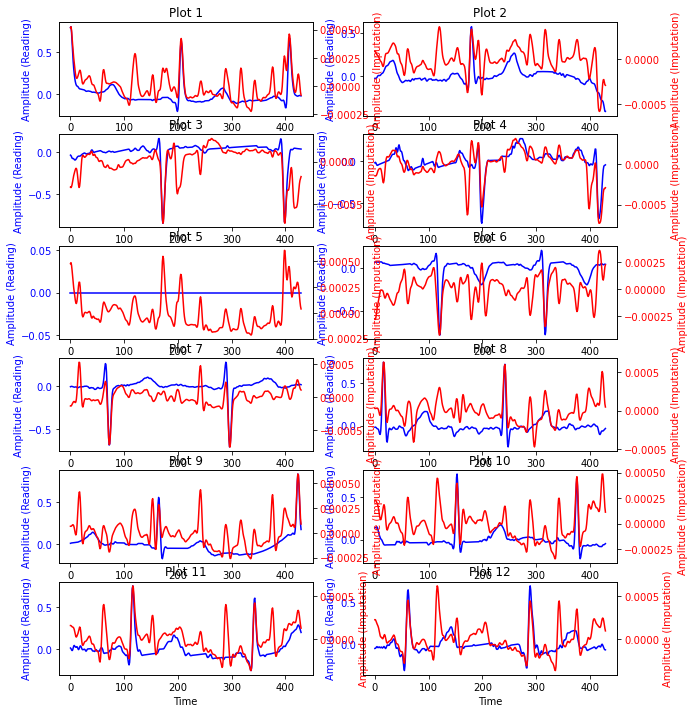

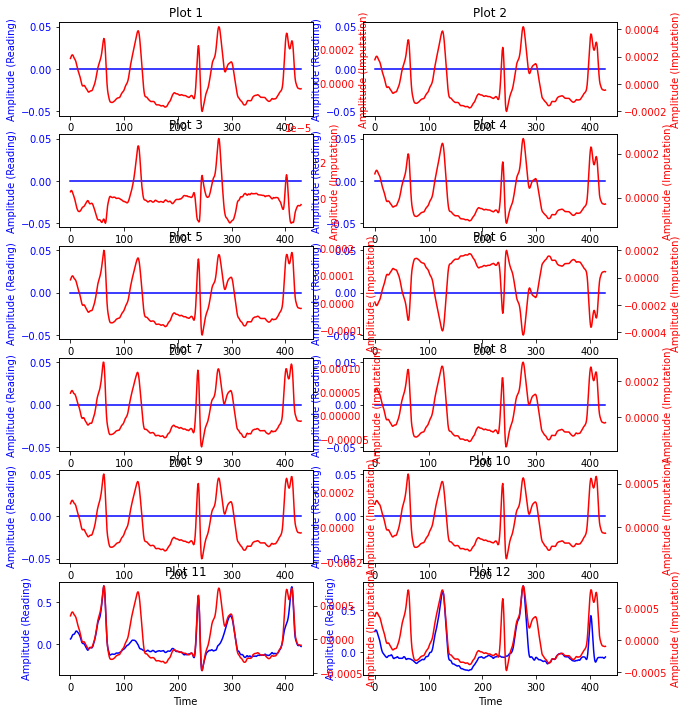

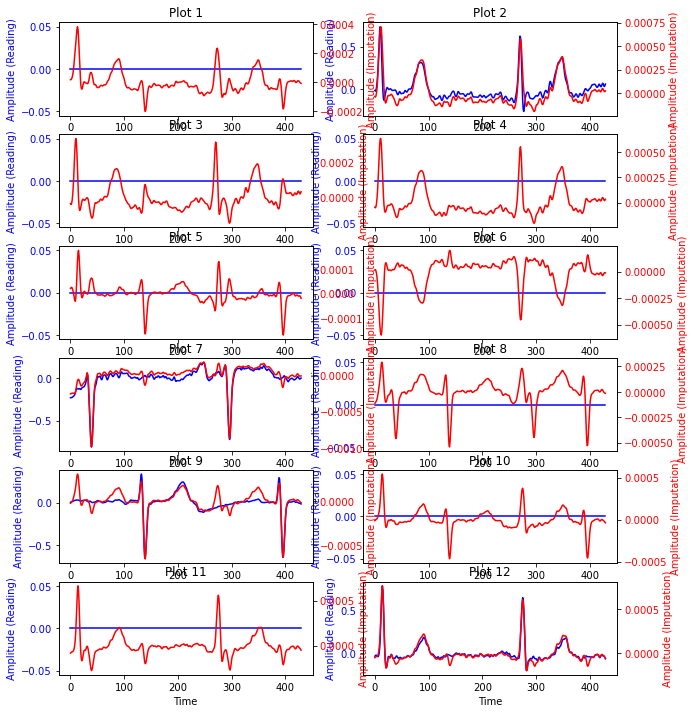

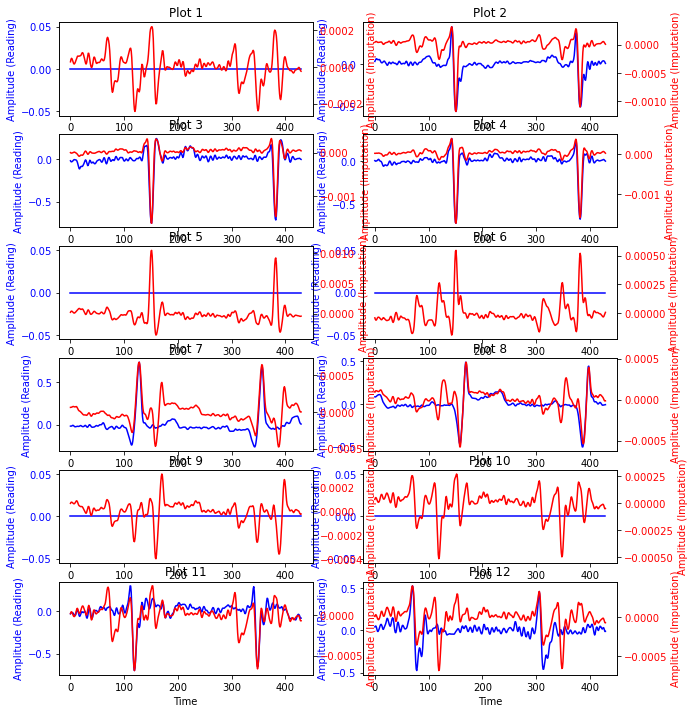

In [108]:
import matplotlib.pyplot as plt
# m = 1
for m in range(4):
    reconstruction_X_ = reconstruction_X.permute((1,2,0))

    # Assuming X_perm and reconstruction_X_ are already defined
    fig, axes = plt.subplots(6, 2, figsize=(10, 12))
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        
        # Plot X_perm data (first y-axis)
        # ax.plot(X_perm[m][i, 10:440] - X_perm[m][i, 10:440].mean(), label="Reading", color='b')
        ax.plot(X[m][i, 10:440] - X[m][i, 10:440].mean(), label="Reading", color='b')
        
        # Create a second y-axis
        ax2 = ax.twinx()
        
        # Plot reconstruction_X_ data (second y-axis)
        ax2.plot(reconstruction_X_[m][i, 10:440] - reconstruction_X_[m][i, 10:440].mean(), label="Imputation", color='r')
        
        # Labels and title
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude (Reading)", color='b')
        ax2.set_ylabel("Amplitude (Imputation)", color='r')
        
        # Optional: You can set the title for each subplot
        ax.set_title(f"Plot {i + 1}")
        
        # Make sure to set the color of the y-axis labels to match the lines
        ax.tick_params(axis='y', labelcolor='b')
        ax2.tick_params(axis='y', labelcolor='r')
    
